In [6]:
import pandas as pd
import numpy as np
import os, json, re, glob
from os.path import join
from netneurotools import datasets as nntdata
from neuromaps.parcellate import Parcellater

from nilearn import image, plotting
from surfplot import Plot

from neuromaps.datasets import fetch_fslr
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti



# gradient color bar
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba
import seaborn as sns

AttributeError: partially initialized module 'pandas' has no attribute 'core' (most likely due to a circular import)

## functin: gradient color bar

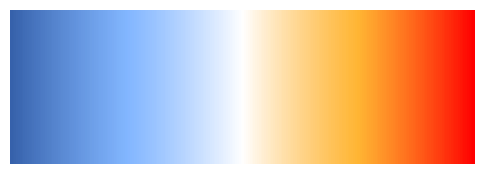

In [ ]:
# Define the colors at specific points
colors = [
    (-1.8, "#120041"),  # Start with blue at -1.9
    (-1.2, "#2500fa"),
    (-0.6, "#84c6fd"),  # Start with blue at -1.9
    (0, "white"),    # Transition to white at 0
    (0.4, "#d50044"),
    (0.8, "#ff0000"),    # Start transitioning to red just after 0 towards 1.2
    (1.2, "#ffd400")  # End with yellow at 1.2
]

colors_with_opacity = [
    (-1.8, to_rgba("#3661ab", alpha=1.0)),  # Fully opaque
    (-0.9, to_rgba("#63a4ff", alpha=0.8)),  # Fully opaque
    # (-0.1, to_rgba("#008bff", alpha=0.6)),  # Fully opaque
    (0, to_rgba("white", alpha=1.0)),       # Fully opaque
    # (0.1, to_rgba("#d50044", alpha=0.6)),   # 30% opacity
    (0.6, to_rgba("#ffa300", alpha=0.8)),   # 60% opacity
    (1.2, to_rgba("#ff0000", alpha=1.0))    # Fully opaque
]



# Normalize the points to the [0, 1] interval
norm_points = np.linspace(-1.9, 1.2, len(colors_with_opacity))
norm_colors = [c[1] for c in colors_with_opacity]
norm_points = (norm_points - norm_points.min()) / (norm_points.max() - norm_points.min())

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list("custom_gradient", list(zip(norm_points, norm_colors)))

# Create a gradient image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot the gradient
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_axis_off()

plt.show()


# gradient


# function for brain plot

In [ ]:
# %%


def plot_brain_surfaces(image, cbar_label='INSERT LABEL', cmap='viridis', color_range=None):
    """
    Plot brain surfaces with the given data.

    Parameters:
    - TST: Tuple of (left hemisphere data, right hemisphere data) to be plotted.
    - cbar_label: 
    - cmap: Colormap for the data.
    - color_range: Optional. Tuple of (min, max) values for the color range. If not provided, the range is auto-detected.
    """
    surfaces_fslr = fetch_fslr()
    lh_fslr, rh_fslr = surfaces_fslr['inflated']
    
    p = Plot(surf_lh=lh_fslr,
             surf_rh=rh_fslr, 
             size=(5000, 1000), 
             zoom=1.2, layout='row', 
             views=['lateral', 'medial', 'ventral', 'posterior'], 
             mirror_views=True, brightness=.7)
    p.add_layer({'left': image[0], 
            'right': image[1]}, 
            cmap=cmap, cbar=True,
            color_range=color_range,
            cbar_label=cbar_label
            ) # YlOrRd_r

    cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=3)
    fig = p.build(cbar_kws=cbar_kws)
    return(fig)
    # fig.show()


## stack xcorr data
previously, I had a bug where the dataframe was stacking sub-all.tsv. This led to an inflation in datapoints.
This bug is resolved by saving the file in a different folder, no longer being globbed and concatenated

In [ ]:
xcorr_dir = '/Volumes/spacetop_projects_cue/analysis/physio/nobaseline/xcorr'

all_frames = []  
xcorr_flist = glob.glob(join(xcorr_dir, f"sub-*_ses-*_run*_runtype-pain_xcorr-fmri-physio.tsv"))
for xcorr_fname in xcorr_flist:
# for filename in os.listdir(xcorr_dir):
    if xcorr_fname.endswith('.tsv'):  # Assuming the files are CSVs
        # file_path = os.path.join(xcorr_dir, filename)
        df = pd.read_csv(xcorr_fname, sep='\t')
        all_frames.append(df)
combined_df = pd.concat(all_frames, ignore_index=True)

from pathlib import Path
Path(join(xcorr_dir, 'total')).mkdir(exist_ok=True, parents=True)
combined_df.to_csv(join(xcorr_dir, 'total', 'sub-all_runtype-pain_xcorr-fmri-physio.tsv'), sep='\t', index=False)

In [ ]:
xcorr_fname

'/Volumes/spacetop_projects_cue/analysis/physio/nobaseline/xcorr/sub-0133_ses-01_run-03_runtype-pain_xcorr-fmri-physio.tsv'

In [3]:
xcorr_dir = '/Volumes/spacetop_projects_cue/analysis/physio/nobaseline/xcorr_canlab2023'

combined_df = pd.read_csv(join(xcorr_dir, 'total', 'sub-all_runtype-pain_xcorr-fmri-physio.tsv'), sep='\t')


NameError: name 'pd' is not defined

In [ ]:
# remove unnecessary columns and rows with NA values
df = combined_df.drop(columns=['Unnamed: 0'])
df = df.dropna()
df.head()

,sub,ses,run,roi,Maximum Correlation Value,Time Lag (s)
0,sub-0061,ses-04,run-03,0.0,-0.002012,6.90
1,sub-0061,ses-04,run-03,1.0,-0.000938,-4.14
2,sub-0061,ses-04,run-03,2.0,0.001538,8.74
3,sub-0061,ses-04,run-03,3.0,0.000971,-1.84
4,sub-0061,ses-04,run-03,4.0,0.001203,8.74


In [ ]:
len(df)

112230

In [ ]:
# Counting frequency of each 'sub' value
frequency = df.groupby('sub').size().reset_index(name='xcorr_frequency_including_400roi')
frequency['run_freq'] = frequency['xcorr_frequency_including_400roi'] / 400


In [ ]:
sum(frequency.run_freq)/78

3.5971153846153845

In [ ]:
frequency

,sub,xcorr_frequency_including_400roi,run_freq
0,sub-0015,800,2.0
1,sub-0016,2000,5.0
2,sub-0017,800,2.0
3,sub-0026,1200,3.0
4,sub-0028,800,2.0
...,...,...,...
62,sub-0119,800,2.0
63,sub-0122,400,1.0
64,sub-0131,1600,4.0
65,sub-0132,2400,6.0


In [ ]:
frequency.run_freq.min()

1.0

In [ ]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10 

min: -0.2578211812360874, max:0.2237134680924523


Text(0.5, 1.0, 'Distribution of cross-correlation values\nMin: -0.258,  Max: 0.224')

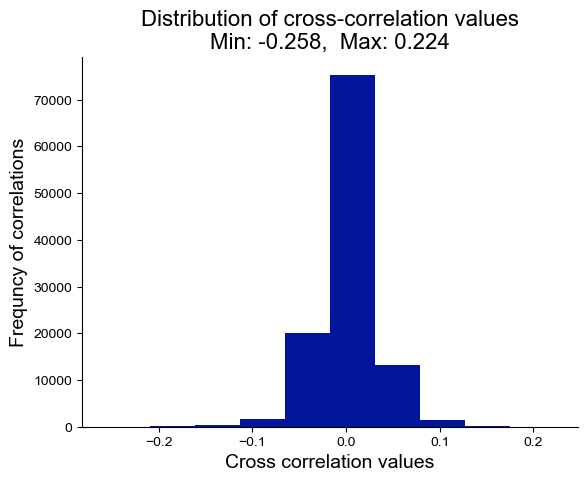

In [ ]:
plt.hist(df['Maximum Correlation Value'], color='#01169D')
print(f"min: {df['Maximum Correlation Value'].min()}, max:{df['Maximum Correlation Value'].max()}")
sns.despine()
plt.xlabel('Cross correlation values', fontsize=14)
plt.ylabel('Frequncy of correlations', fontsize=14)
plt.title(f"Distribution of cross-correlation values\nMin: {round(df['Maximum Correlation Value'].min(), 3)},  Max: {round(df['Maximum Correlation Value'].max(), 3)}", fontsize=16)



## fisher z transform

In [ ]:
def fisher_z_transform(r):
    return np.arctanh(r)

df['Max_Corr_Value_Z']  = df.groupby('sub')['Maximum Correlation Value'].transform(fisher_z_transform)
# df['Max_Corr_Value_Z'] = df['Maximum Correlation Value'].apply(fisher_z_transform)


In [ ]:
df

,sub,ses,run,roi,Maximum Correlation Value,Time Lag (s),Max_Corr_Value_Z
0,sub-0061,ses-04,run-03,0.0,-0.002012,6.90,-0.002012
1,sub-0061,ses-04,run-03,1.0,-0.000938,-4.14,-0.000938
2,sub-0061,ses-04,run-03,2.0,0.001538,8.74,0.001538
3,sub-0061,ses-04,run-03,3.0,0.000971,-1.84,0.000971
4,sub-0061,ses-04,run-03,4.0,0.001203,8.74,0.001203
...,...,...,...,...,...,...,...
112395,sub-0133,ses-01,run-03,395.0,0.013704,5.06,0.013705
112396,sub-0133,ses-01,run-03,396.0,0.017394,0.46,0.017396
112397,sub-0133,ses-01,run-03,397.0,0.015708,0.92,0.015709
112398,sub-0133,ses-01,run-03,398.0,-0.015356,8.28,-0.015357


## calculate summary statistics
here, I average Maximum corr values, time lags 
* first by calculating 1) within runs, 
* then 2) aggregating corr values, time lags per roi averaged within subs, 
* then 3) group level stats per ROI

In [ ]:
avg_per_ses = df.groupby(['sub', 'ses', 'roi']).mean().reset_index()
avg_per_sub = avg_per_ses.groupby(['sub', 'roi']).mean().reset_index()

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_50120/42949844.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_per_ses = df.groupby(['sub', 'ses', 'roi']).mean().reset_index()
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_50120/42949844.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_per_sub = avg_per_ses.groupby(['sub', 'roi']).mean().reset_index()


In [ ]:
avg_per_sub

,sub,roi,Maximum Correlation Value,Time Lag (s),Max_Corr_Value_Z
0,sub-0015,0.0,-0.022372,3.450000,-0.022462
1,sub-0015,1.0,-0.017306,3.450000,-0.017327
2,sub-0015,2.0,-0.013334,3.910000,-0.013348
3,sub-0015,3.0,-0.066055,4.600000,-0.066154
4,sub-0015,4.0,-0.056839,5.060000,-0.056914
...,...,...,...,...,...
26795,sub-0133,395.0,0.022658,5.443333,0.022678
26796,sub-0133,396.0,0.032922,5.290000,0.032951
26797,sub-0133,397.0,0.011684,5.596667,0.011695
26798,sub-0133,398.0,0.014798,6.286667,0.014811


In [ ]:
import pandas as pd
import scipy.stats

# Assuming df is your DataFrame

# Define a list to store the results
results = []

# Group by 'roi' and run t-test on each group
for roi, group in avg_per_sub.groupby('roi'):
    # Extract the 'Maximum Correlation Value' for the current group
    values = group['Maximum Correlation Value']
    
    # Perform the one-sample t-test against the population mean of 0
    t, p = scipy.stats.ttest_1samp(values, popmean=0)
    
    # Append the results for the current ROI
    results.append({'roi': roi, 
    't-value': t, 
    'p-value': p, 
    'mean_xcor': np.tanh(np.nanmean(values, axis=0))
    })

# Convert the results list into a DataFrame
results_df = pd.DataFrame(results)

# Show or save the results
print(results_df)


       roi   t-value   p-value  mean_xcor
0      0.0  2.477070  0.015816   0.006216
1      1.0  1.232825  0.222015   0.002059
2      2.0  4.215852  0.000077   0.009452
3      3.0  0.200021  0.842079   0.000435
4      4.0 -0.111574  0.911500  -0.000255
..     ...       ...       ...        ...
395  395.0  3.103968  0.002811   0.006682
396  396.0  2.698434  0.008837   0.004675
397  397.0  0.211282  0.833318   0.000464
398  398.0  3.095145  0.002885   0.006550
399  399.0  2.107078  0.038915   0.004435

[400 rows x 4 columns]


In [ ]:
# non_significant = results_df[results_df['p-value'] <= 0.05]
# non_significant
from statsmodels.stats.multitest import multipletests

p_adjusted = multipletests(results_df['p-value'], alpha=0.05, method='fdr_bh')
p_adjusted

(array([False, False,  True, False, False,  True, False,  True, False,
        False, False, False, False,  True, False, False,  True, False,
         True, False, False, False,  True, False, False, False,  True,
         True, False, False,  True, False, False, False,  True,  True,
        False,  True, False, False,  True, False, False, False, False,
         True, False, False, False, False,  True,  True,  True, False,
        False, False,  True,  True,  True, False,  True, False, False,
        False,  True, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False, False, False, False,  True,  True, False,  True,
         True, False, False,  True, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False, False,
      

In [ ]:
adjusted_p_values = p_adjusted[2]
adjusted_p_values

0.00012822501443887635

In [ ]:
df.columns

Index(['sub', 'ses', 'run', 'roi', 'Maximum Correlation Value', 'Time Lag (s)',
       'Max_Corr_Value_Z'],
      dtype='object')

In [ ]:

group_level_avg = avg_per_sub.groupby('roi').median().reset_index()
group_level_avg['Avg_Max_Corr_Value'] = np.tanh(group_level_avg['Max_Corr_Value_Z'])
xcorr_stat = group_level_avg.merge(results_df, how='inner', on='roi')

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_50120/1528042375.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  group_level_avg = avg_per_sub.groupby('roi').median().reset_index()


## subjectwise T

In [ ]:
subjectwise_results = []
for (roi, subject), group in df.groupby(['roi', 'sub']):
    values = group['Maximum Correlation Value'].values
    
    t, p = scipy.stats.ttest_1samp(values, popmean=0)
    # if roi not in t_map:
    #     t_map[roi] = {}
    #     p_map[roi] = {}
    
    subjectwise_results.append({
        'sub':subject,
        'roi': roi, 
    't-value': t, 
    'p-value': p, 
    'mean_xcor': np.tanh(np.nanmean(values, axis=0))
    })
subjectwise_results_df = pd.DataFrame(subjectwise_results)
subjectwise_clean = subjectwise_results_df.dropna()
#     # Store the t and p values
#     t_map[roi][subject] = t
#     p_map[roi][subject] = p
# t_map_df = pd.DataFrame(t_map).T  # Transpose to have ROIs as rows and subjects as columns
# p_map_df = pd.DataFrame(p_map).T  # Transpose to have ROIs as rows and subjects as columns


/Users/h/miniconda3/envs/physio/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/h/miniconda3/envs/physio/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [ ]:
import numpy as np
import pandas as pd
import scipy.stats

# Group by ROI and calculate mean of the 'Maximum Correlation Value'
group_means = subjectwise_clean.groupby('roi')['mean_xcor'].mean().reset_index()

# Initialize list to hold group-level t and p values
group_level_stats = []

# Perform a one-sample t-test for the group mean against the population mean (0) for each ROI
for index, row in group_means.iterrows():
    # Assuming you're testing against a population mean of 0
    t, p = scipy.stats.ttest_1samp(subjectwise_clean[subjectwise_clean['roi'] == row['roi']]['mean_xcor'], 0)
    
    # Append group-level stats
    group_level_stats.append({'roi': row['roi'], 't-value': t, 'p-value': p, 'mean_xcorr': row['mean_xcor']})

# Convert to DataFrame
group_level_stats_df = pd.DataFrame(group_level_stats)


# multiple comparisons
from statsmodels.stats.multitest import multipletests

# Extract p-values
p_values = group_level_stats_df['p-value'].values

# Apply Benjamini-Hochberg FDR correction
_, corrected_p_values, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

# Add corrected p-values to the DataFrame
group_level_stats_df['corrected_p-value'] = corrected_p_values
np.sum(group_level_stats_df['corrected_p-value'] < .05)
group_level_stats_df.head()
group_level_stats_df['Time Lag (s)'] = group_level_avg['Time Lag (s)']


In [ ]:
group_level_stats_df

,roi,t-value,p-value,mean_xcorr,corrected_p-value,Time Lag (s)
0,0.0,2.596796,0.011661,0.006622,0.048086,4.945000
1,1.0,1.036656,0.303797,0.001761,0.504228,4.830000
2,2.0,3.949205,0.000198,0.009316,0.002730,5.750000
3,3.0,0.487443,0.627610,0.001032,0.760739,5.520000
4,4.0,0.007689,0.993889,0.000018,0.996380,5.366667
...,...,...,...,...,...,...
395,395.0,2.724112,0.008302,0.005937,0.038823,5.290000
396,396.0,2.596712,0.011663,0.004654,0.048086,5.290000
397,397.0,0.211421,0.833231,0.000480,0.900790,5.366667
398,398.0,2.655945,0.009971,0.005359,0.043352,5.290000


## plot

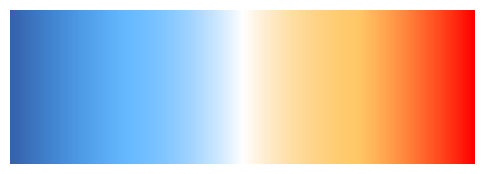

In [ ]:
# Define the colors at specific points
colors = [
    (-0.01, "#120041"),  # Start with blue at -1.9
    (-0.005, "#2500fa"),
    (-0.001, "#84c6fd"),  # Start with blue at -1.9
    (0, "white"),    # Transition to white at 0
    (0.001, "#d50044"),
    (0.005, "#ff0000"),    # Start transitioning to red just after 0 towards 1.2
    (0.010, "#ffd400")  # End with yellow at 1.2
]

colors_with_opacity = [
    (-0.010, to_rgba("#3661ab", alpha=1.0)),  # Fully opaque
    # (-0.005, to_rgba("#63a4ff", alpha=0.8)),  # Fully opaque
    (-0.001, to_rgba("#008bff", alpha=0.6)),  # Fully opaque
    (0, to_rgba("white", alpha=1.0)),       # Fully opaque
    (0.001, to_rgba("#ffa300", alpha=0.6)),   # 30% opacity
    # (0.005, to_rgba("#ffa300", alpha=0.8)),   # 60% opacity
    (0.010, to_rgba("#ff0000", alpha=1.0))    # Fully opaque
]



# Normalize the points to the [0, 1] interval
norm_points = np.linspace(0, .064, len(colors_with_opacity))
norm_colors = [c[1] for c in colors_with_opacity]
norm_points = (norm_points - norm_points.min()) / (norm_points.max() - norm_points.min())

# Create a custom colormap
xcorr_cmap = LinearSegmentedColormap.from_list("custom_gradient", list(zip(norm_points, norm_colors)))

# Create a gradient image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot the gradient
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=xcorr_cmap)
ax.set_axis_off()

plt.show()


In [ ]:
group_level_avg

,roi,Maximum Correlation Value,Time Lag (s),Max_Corr_Value_Z,Avg_Max_Corr_Value
0,0.0,0.006812,4.945000,0.006813,0.006813
1,1.0,0.001627,4.830000,0.001627,0.001627
2,2.0,0.010050,5.750000,0.010051,0.010050
3,3.0,0.002482,5.520000,0.002483,0.002483
4,4.0,-0.000120,5.366667,-0.000118,-0.000118
...,...,...,...,...,...
395,395.0,0.007101,5.290000,0.007102,0.007102
396,396.0,0.004153,5.290000,0.004148,0.004148
397,397.0,0.002413,5.366667,0.002413,0.002413
398,398.0,0.003427,5.290000,0.003427,0.003427


# plot X corr

In [ ]:
group_level_stats_df

,roi,t-value,p-value,mean_xcorr,corrected_p-value,xcorr_sig
0,0.0,2.596796,0.011661,0.006622,0.048086,0.006622
1,1.0,1.036656,0.303797,0.001761,0.504228,NaN
2,2.0,3.949205,0.000198,0.009316,0.002730,0.009316
3,3.0,0.487443,0.627610,0.001032,0.760739,NaN
4,4.0,0.007689,0.993889,0.000018,0.996380,NaN
...,...,...,...,...,...,...
395,395.0,2.724112,0.008302,0.005937,0.038823,0.005937
396,396.0,2.596712,0.011663,0.004654,0.048086,0.004654
397,397.0,0.211421,0.833231,0.000480,0.900790,NaN
398,398.0,2.655945,0.009971,0.005359,0.043352,0.005359


In [ ]:
group_level_stats_df['xcorr_sig'] = np.where(group_level_stats_df['corrected_p-value'] < .05, group_level_stats_df['mean_xcorr'], np.nan)
group_level_stats_df['xcorr_sig'].head()
np.sum(group_level_stats_df['xcorr_sig'])

0.7547743963576297

In [ ]:
roi_xcorr

0      0.006622
1           NaN
2      0.009316
3           NaN
4           NaN
         ...   
395    0.005937
396    0.004654
397         NaN
398    0.005359
399         NaN
Name: xcorr_sig, Length: 400, dtype: float64

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


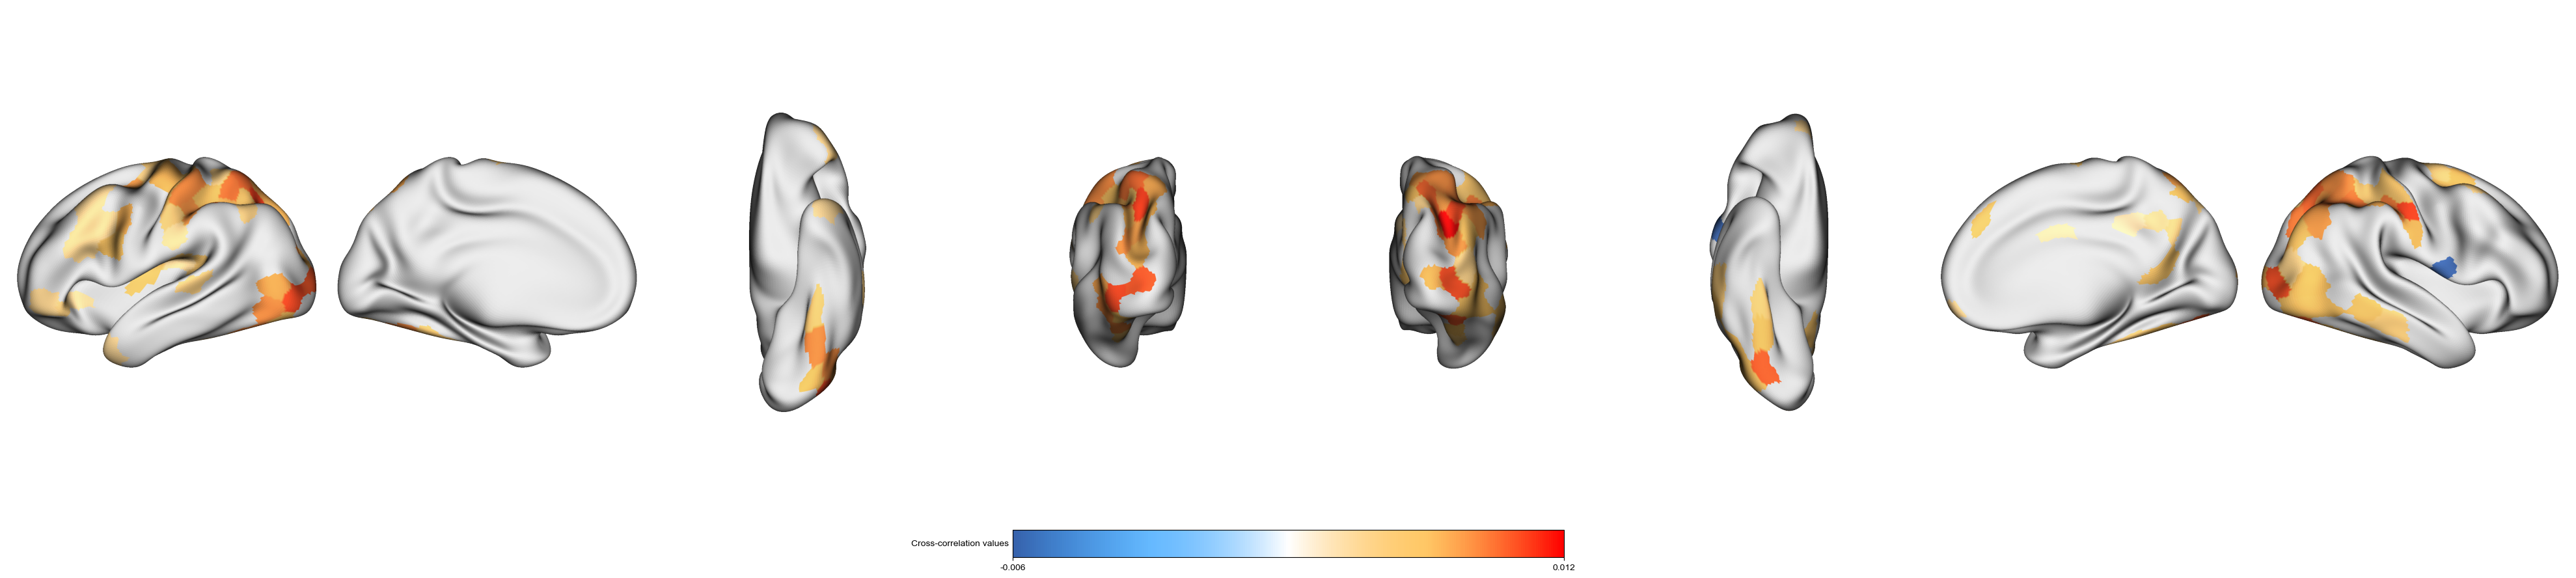

<Figure size 640x480 with 0 Axes>

In [ ]:
schaefer = nntdata.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
parc = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')
roi_xcorr = group_level_stats_df['xcorr_sig']
roidata = parc.inverse_transform(roi_xcorr)

maxval = np.max(roi_xcorr);    minval = np.min(roi_xcorr); sd = np.std(roi_xcorr)
fig = plot_brain_surfaces(image=roidata, cbar_label='Cross-correlation values', cmap=xcorr_cmap, color_range=(minval, maxval))
plt.show()
plt.savefig('Xcorr.png', dpi=300)  # Increase DPI for higher resolution


min: -0.0064718245912826185, max:0.012335471377156336


Text(0.5, 1.0, 'Distribution of cross-correlation values (summary statistics)\nMin: -0.006,  Max: 0.012')

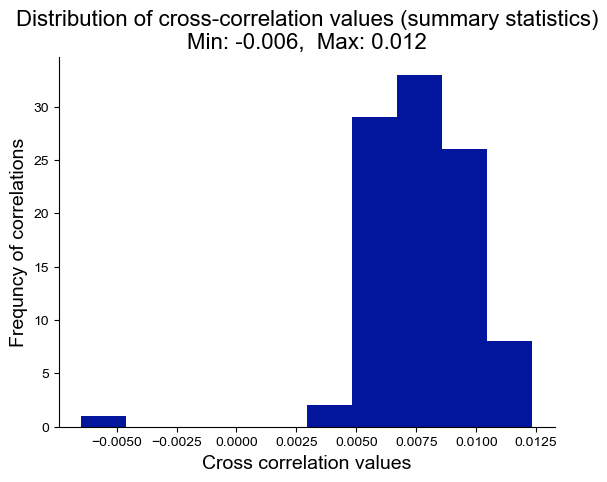

In [ ]:
plt.hist(roi_xcorr)
plt.hist(roi_xcorr, color='#01169D')
print(f"min: {roi_xcorr.min()}, max:{roi_xcorr.max()}")
sns.despine()
plt.xlabel('Cross correlation values', fontsize=14)
plt.ylabel('Frequncy of correlations', fontsize=14)
plt.title(f"Distribution of cross-correlation values (summary statistics)\nMin: {round(roi_xcorr.min(), 3)},  Max: {round(roi_xcorr.max(), 3)}", fontsize=16)



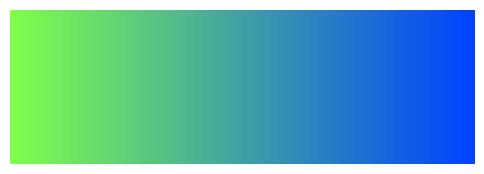

In [ ]:
# Define the colors at specific points
colors = [
    # (-5.4, "#120041"),  # Start with blue at -1.9
    # (-3.6, "#2500fa"),
    # (-1.8, "#84c6fd"),  # Start with blue at -1.9
    (0, "#80ff4a"),    # Transition to white at 0
    # (4, "#fdbb2d"),
    # (5, "#09792c"),    # Start transitioning to red just after 0 towards 1.2
    (12, "#0043ff")  # End with yellow at 1.2
]

colors_with_opacity = [
    # (-5.4, to_rgba("#3661ab", alpha=1.0)),  # Fully opaque
    # (-3.6, to_rgba("#63a4ff", alpha=0.8)),  # Fully opaque
    # (-0.1, to_rgba("#008bff", alpha=0.6)),  # Fully opaque
    (0, to_rgba("#80ff4a", alpha=1.0)),       # Fully opaque
    # (4, to_rgba("#fdbb2d", alpha=0.6)),   # 30% opacity
    # (6, to_rgba("#09792c", alpha=0.8)),   # 60% opacity
    (12, to_rgba("#0043ff", alpha=1.0))    # Fully opaque
]



# Normalize the points to the [0, 1] interval
norm_points = np.linspace(0,12, len(colors_with_opacity))
norm_colors = [c[1] for c in colors_with_opacity]
norm_points = (norm_points - norm_points.min()) / (norm_points.max() - norm_points.min())

# Create a custom colormap
lag_cmap = LinearSegmentedColormap.from_list("custom_gradient", list(zip(norm_points, norm_colors)))

# Create a gradient image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot the gradient
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=lag_cmap)
ax.set_axis_off()

plt.show()


In [ ]:
group_level_stats_df['corrected_p-value'] < .05

0       True
1      False
2       True
3      False
4      False
       ...  
395     True
396     True
397    False
398     True
399    False
Name: corrected_p-value, Length: 400, dtype: bool

In [ ]:
group_level_avg['Time Lag (s)']

0      4.945000
1      4.830000
2      5.750000
3      5.520000
4      5.366667
         ...   
395    5.290000
396    5.290000
397    5.366667
398    5.290000
399    5.520000
Name: Time Lag (s), Length: 400, dtype: float64

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


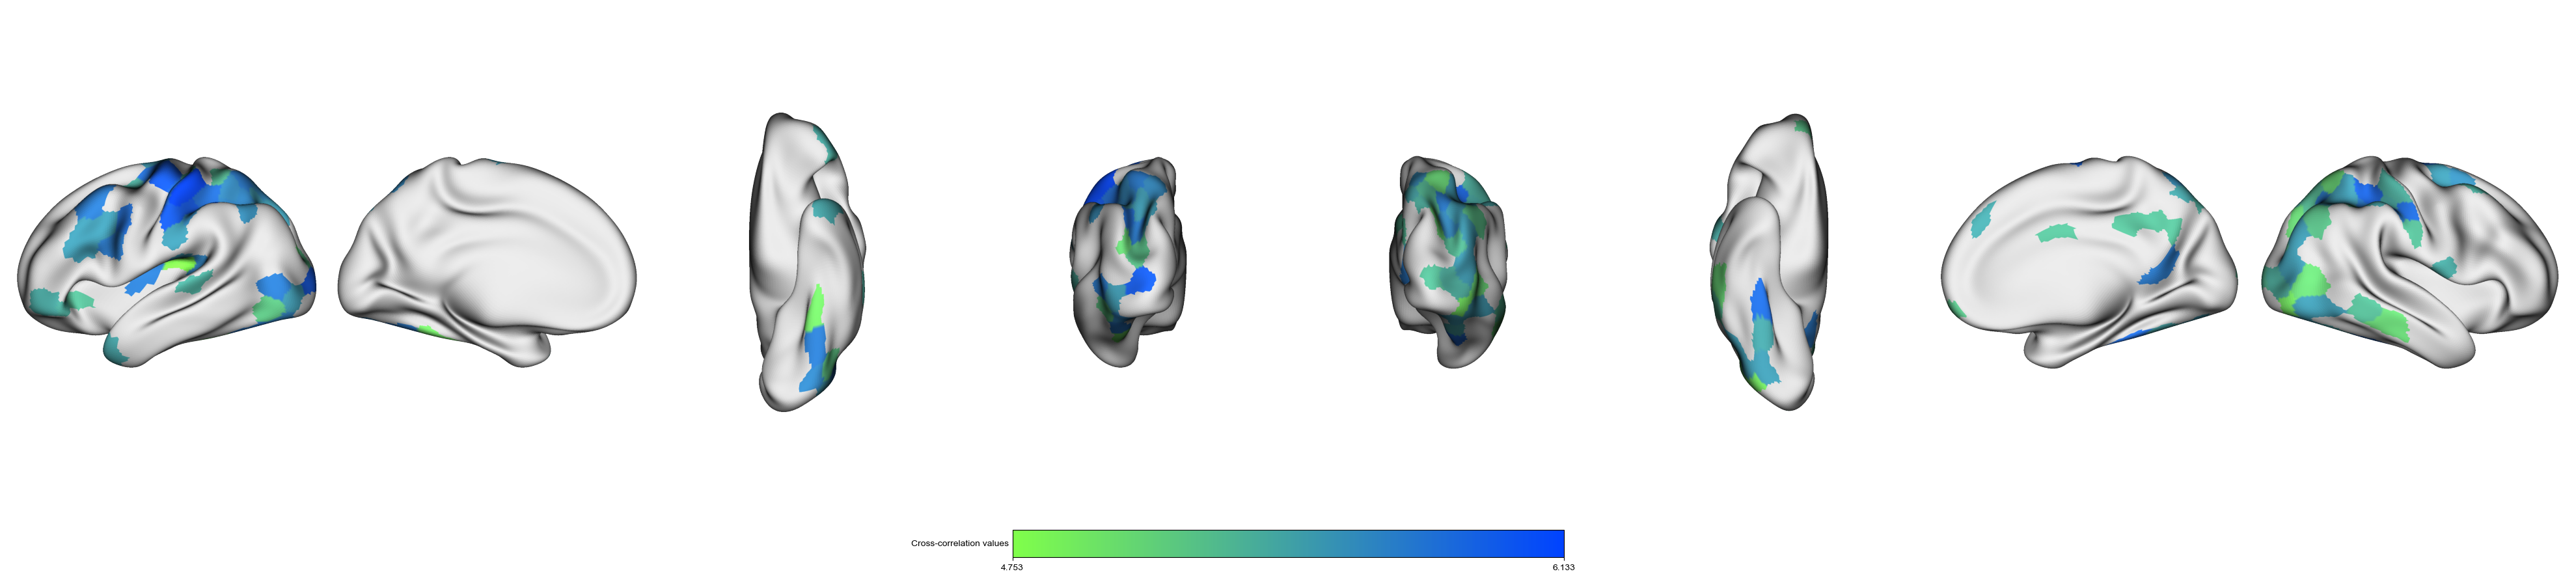

<Figure size 640x480 with 0 Axes>

In [ ]:
schaefer = nntdata.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
parc = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')
# 
group_level_stats_df['lag_sig'] = np.where(group_level_stats_df['corrected_p-value'] < .05,  group_level_stats_df['Time Lag (s)'], np.nan)
roi_timelag = group_level_stats_df['lag_sig']
roitimelag = parc.inverse_transform(roi_timelag)

maxval = np.max(roi_timelag);    minval = np.min(roi_timelag); sd = np.std(roi_timelag)
fig = plot_brain_surfaces(image=roitimelag, cbar_label='Cross-correlation values', cmap=lag_cmap, color_range=(minval, maxval))
plt.show()
plt.savefig('Xcorr_lag.png', dpi=300)  # Increase DPI for higher resolution
